In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 600


In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data.head()

,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


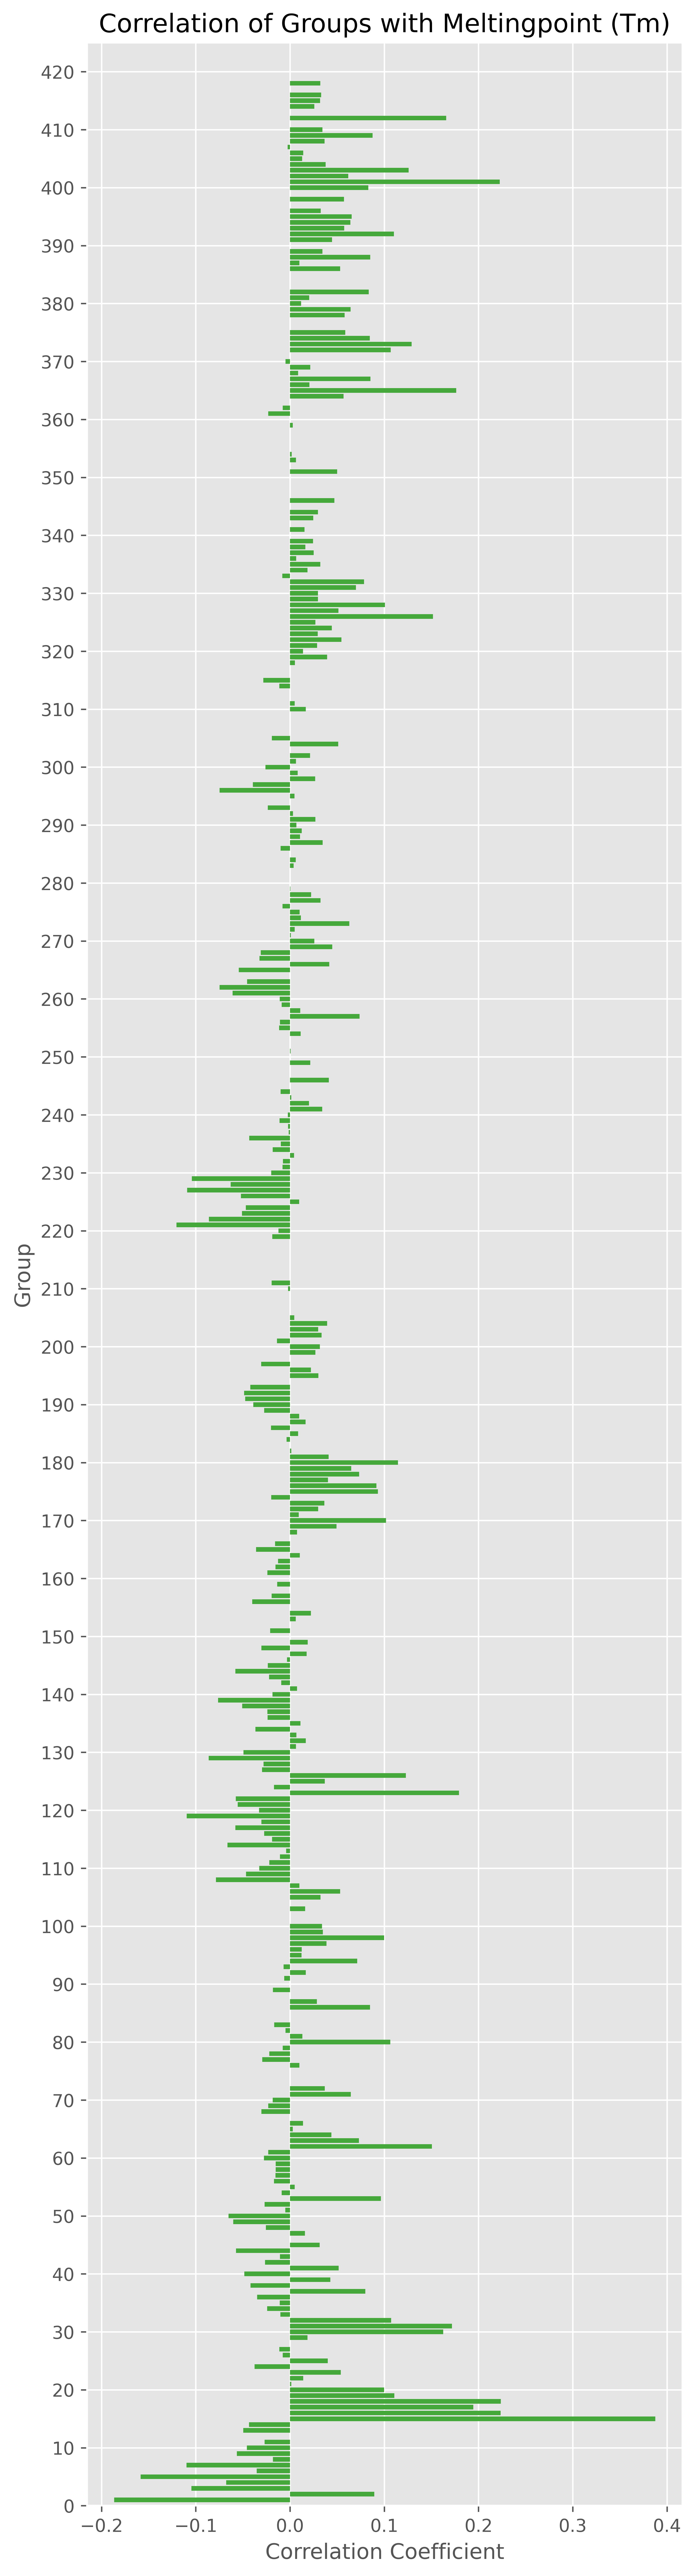

In [3]:
#plotting ideas
groups =[col for col in data.columns if col.startswith('Group')] #names of columns

corr = data[groups + ['Tm']].corr()['Tm'].drop('Tm')
corr_df = corr.reset_index()
corr_df.columns = ["Group", "Correlation"]

corr_df["Group_Number"] = corr_df["Group"].apply(lambda x: int(re.findall(r"\d+", x)[0]))

# sorting group numbers
corr_df = corr_df.sort_values("Group_Number")

plt.figure(figsize=(6, 25))
plt.barh(corr_df["Group_Number"], corr_df["Correlation"], color='#44A83B')
plt.yticks(range(0, corr_df["Group_Number"].max() + 1, 10))
plt.ylim(0, corr_df["Group_Number"].max() + 1)
plt.title("Correlation of Groups with Meltingpoint (Tm)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Group")
#plt.savefig("Graphics/Correlation_plot")
plt.show()
plt.close()


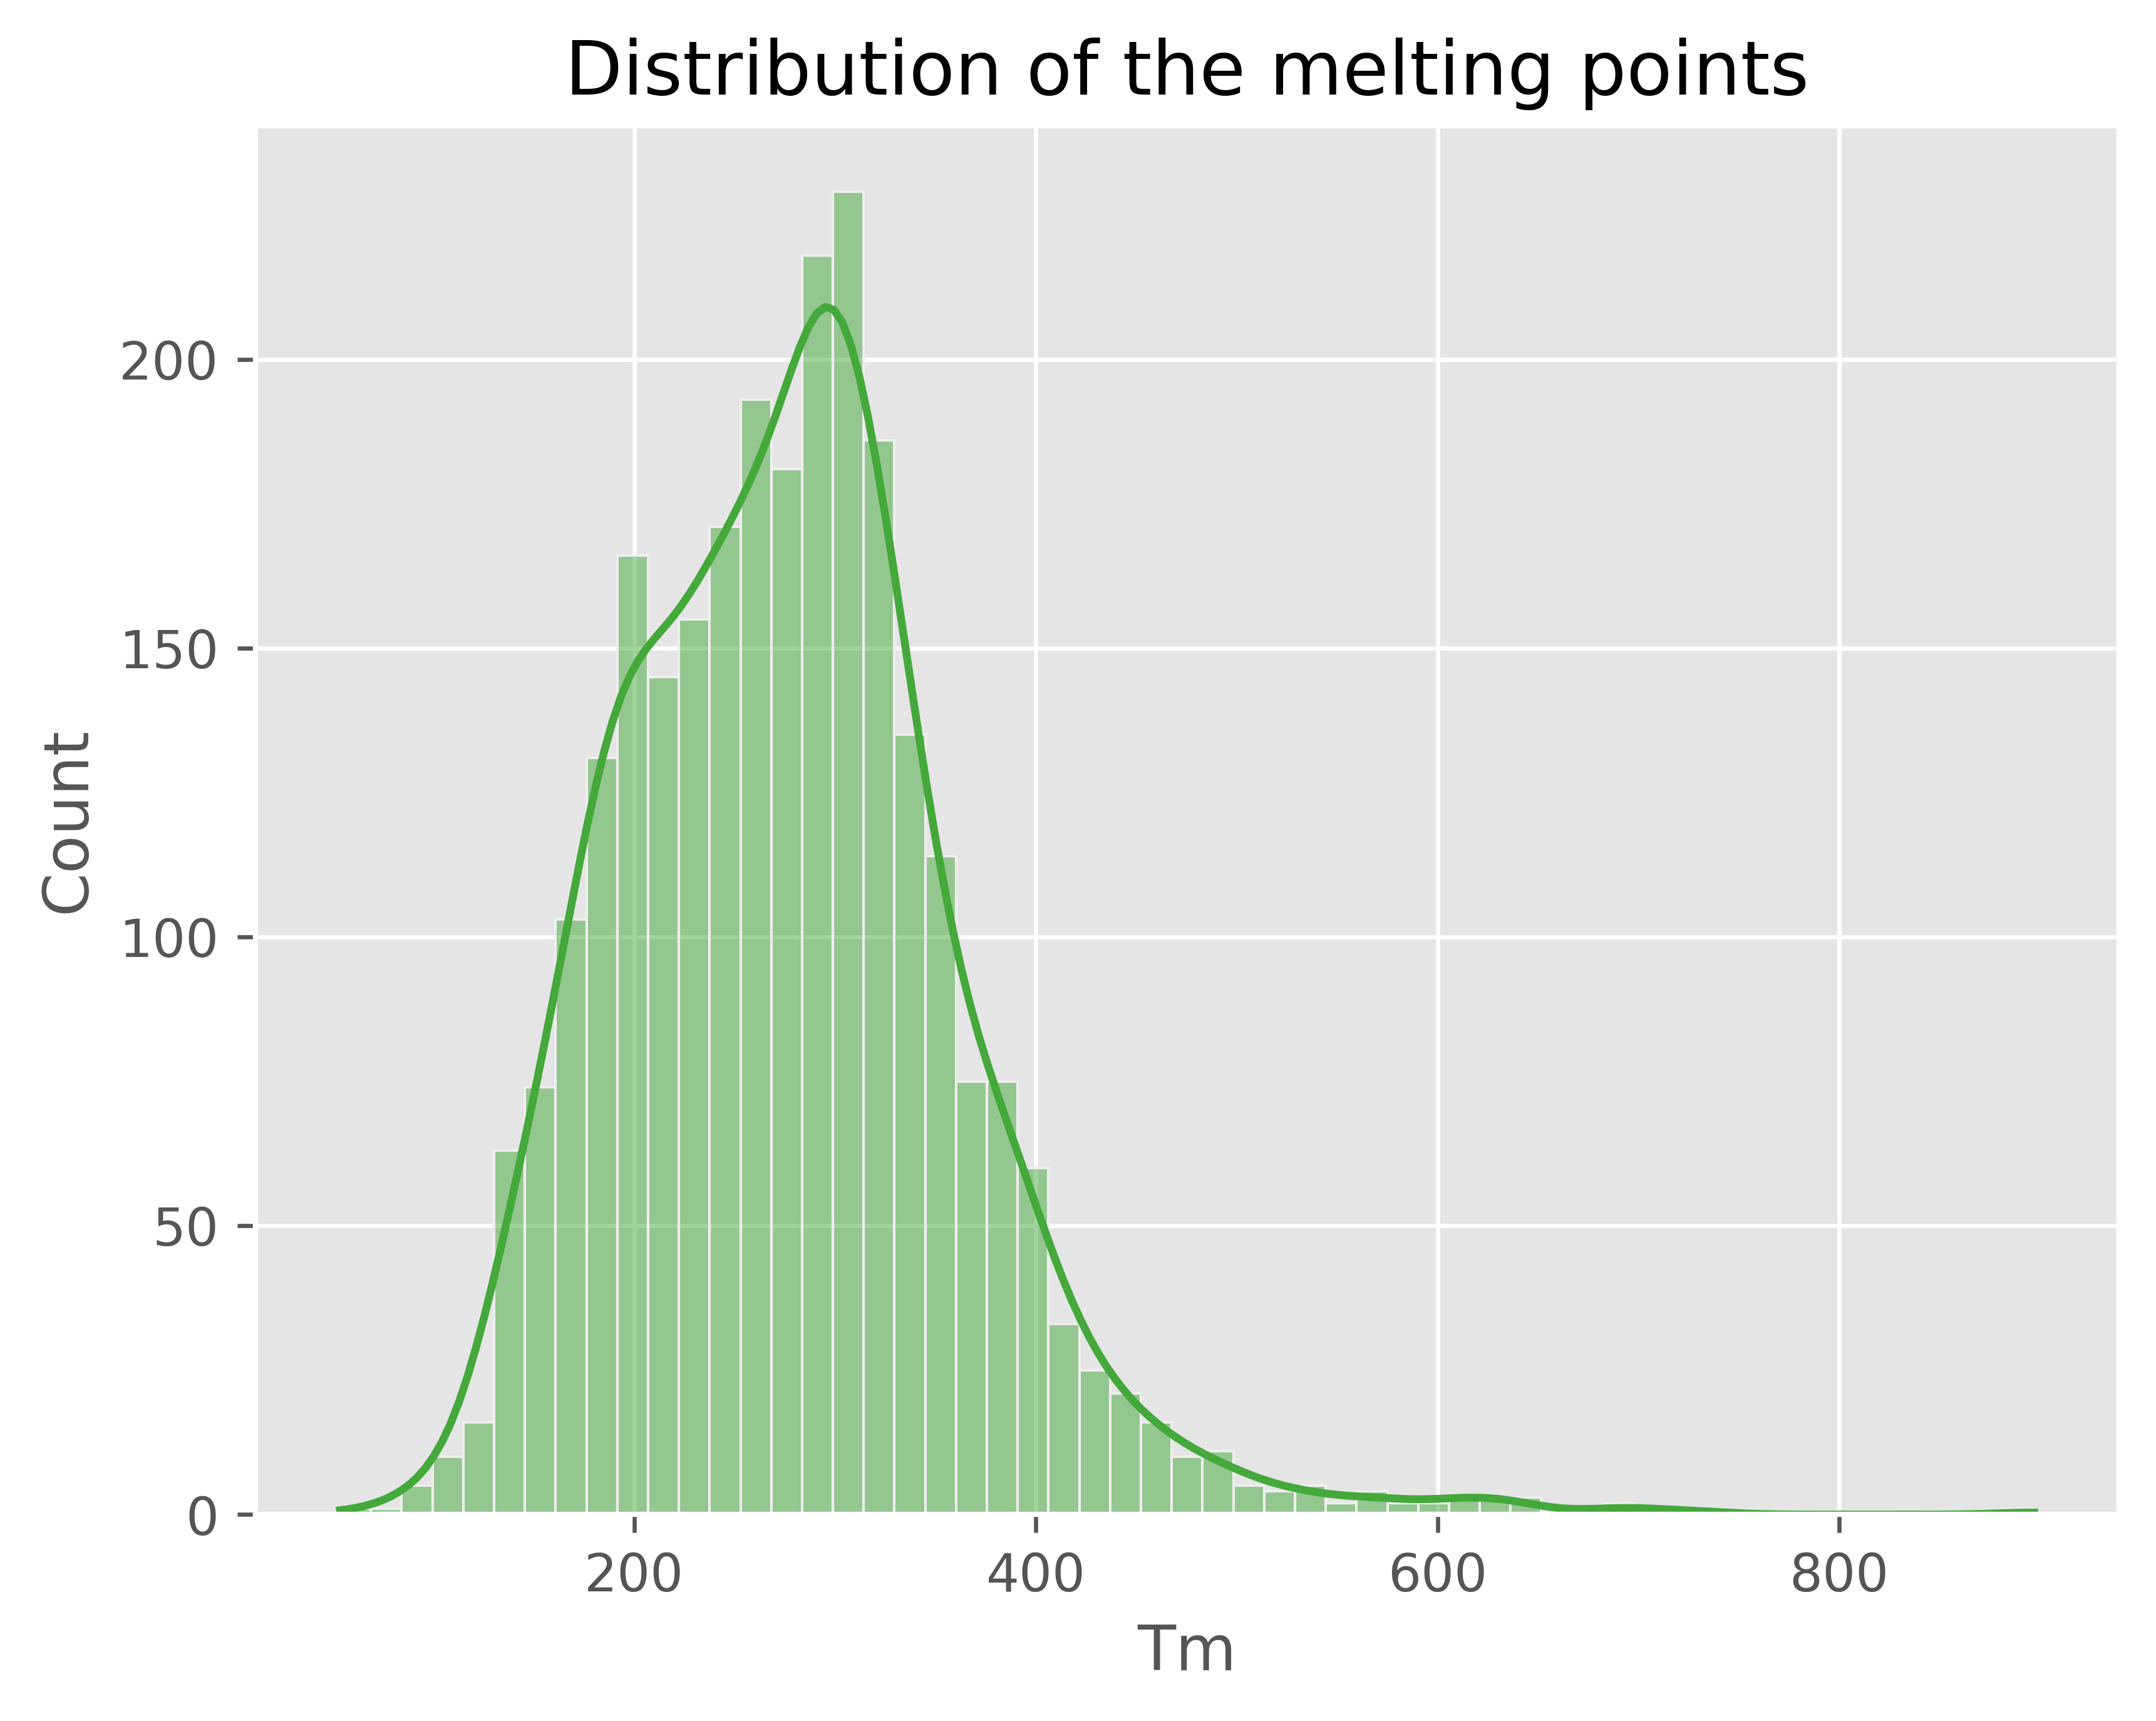

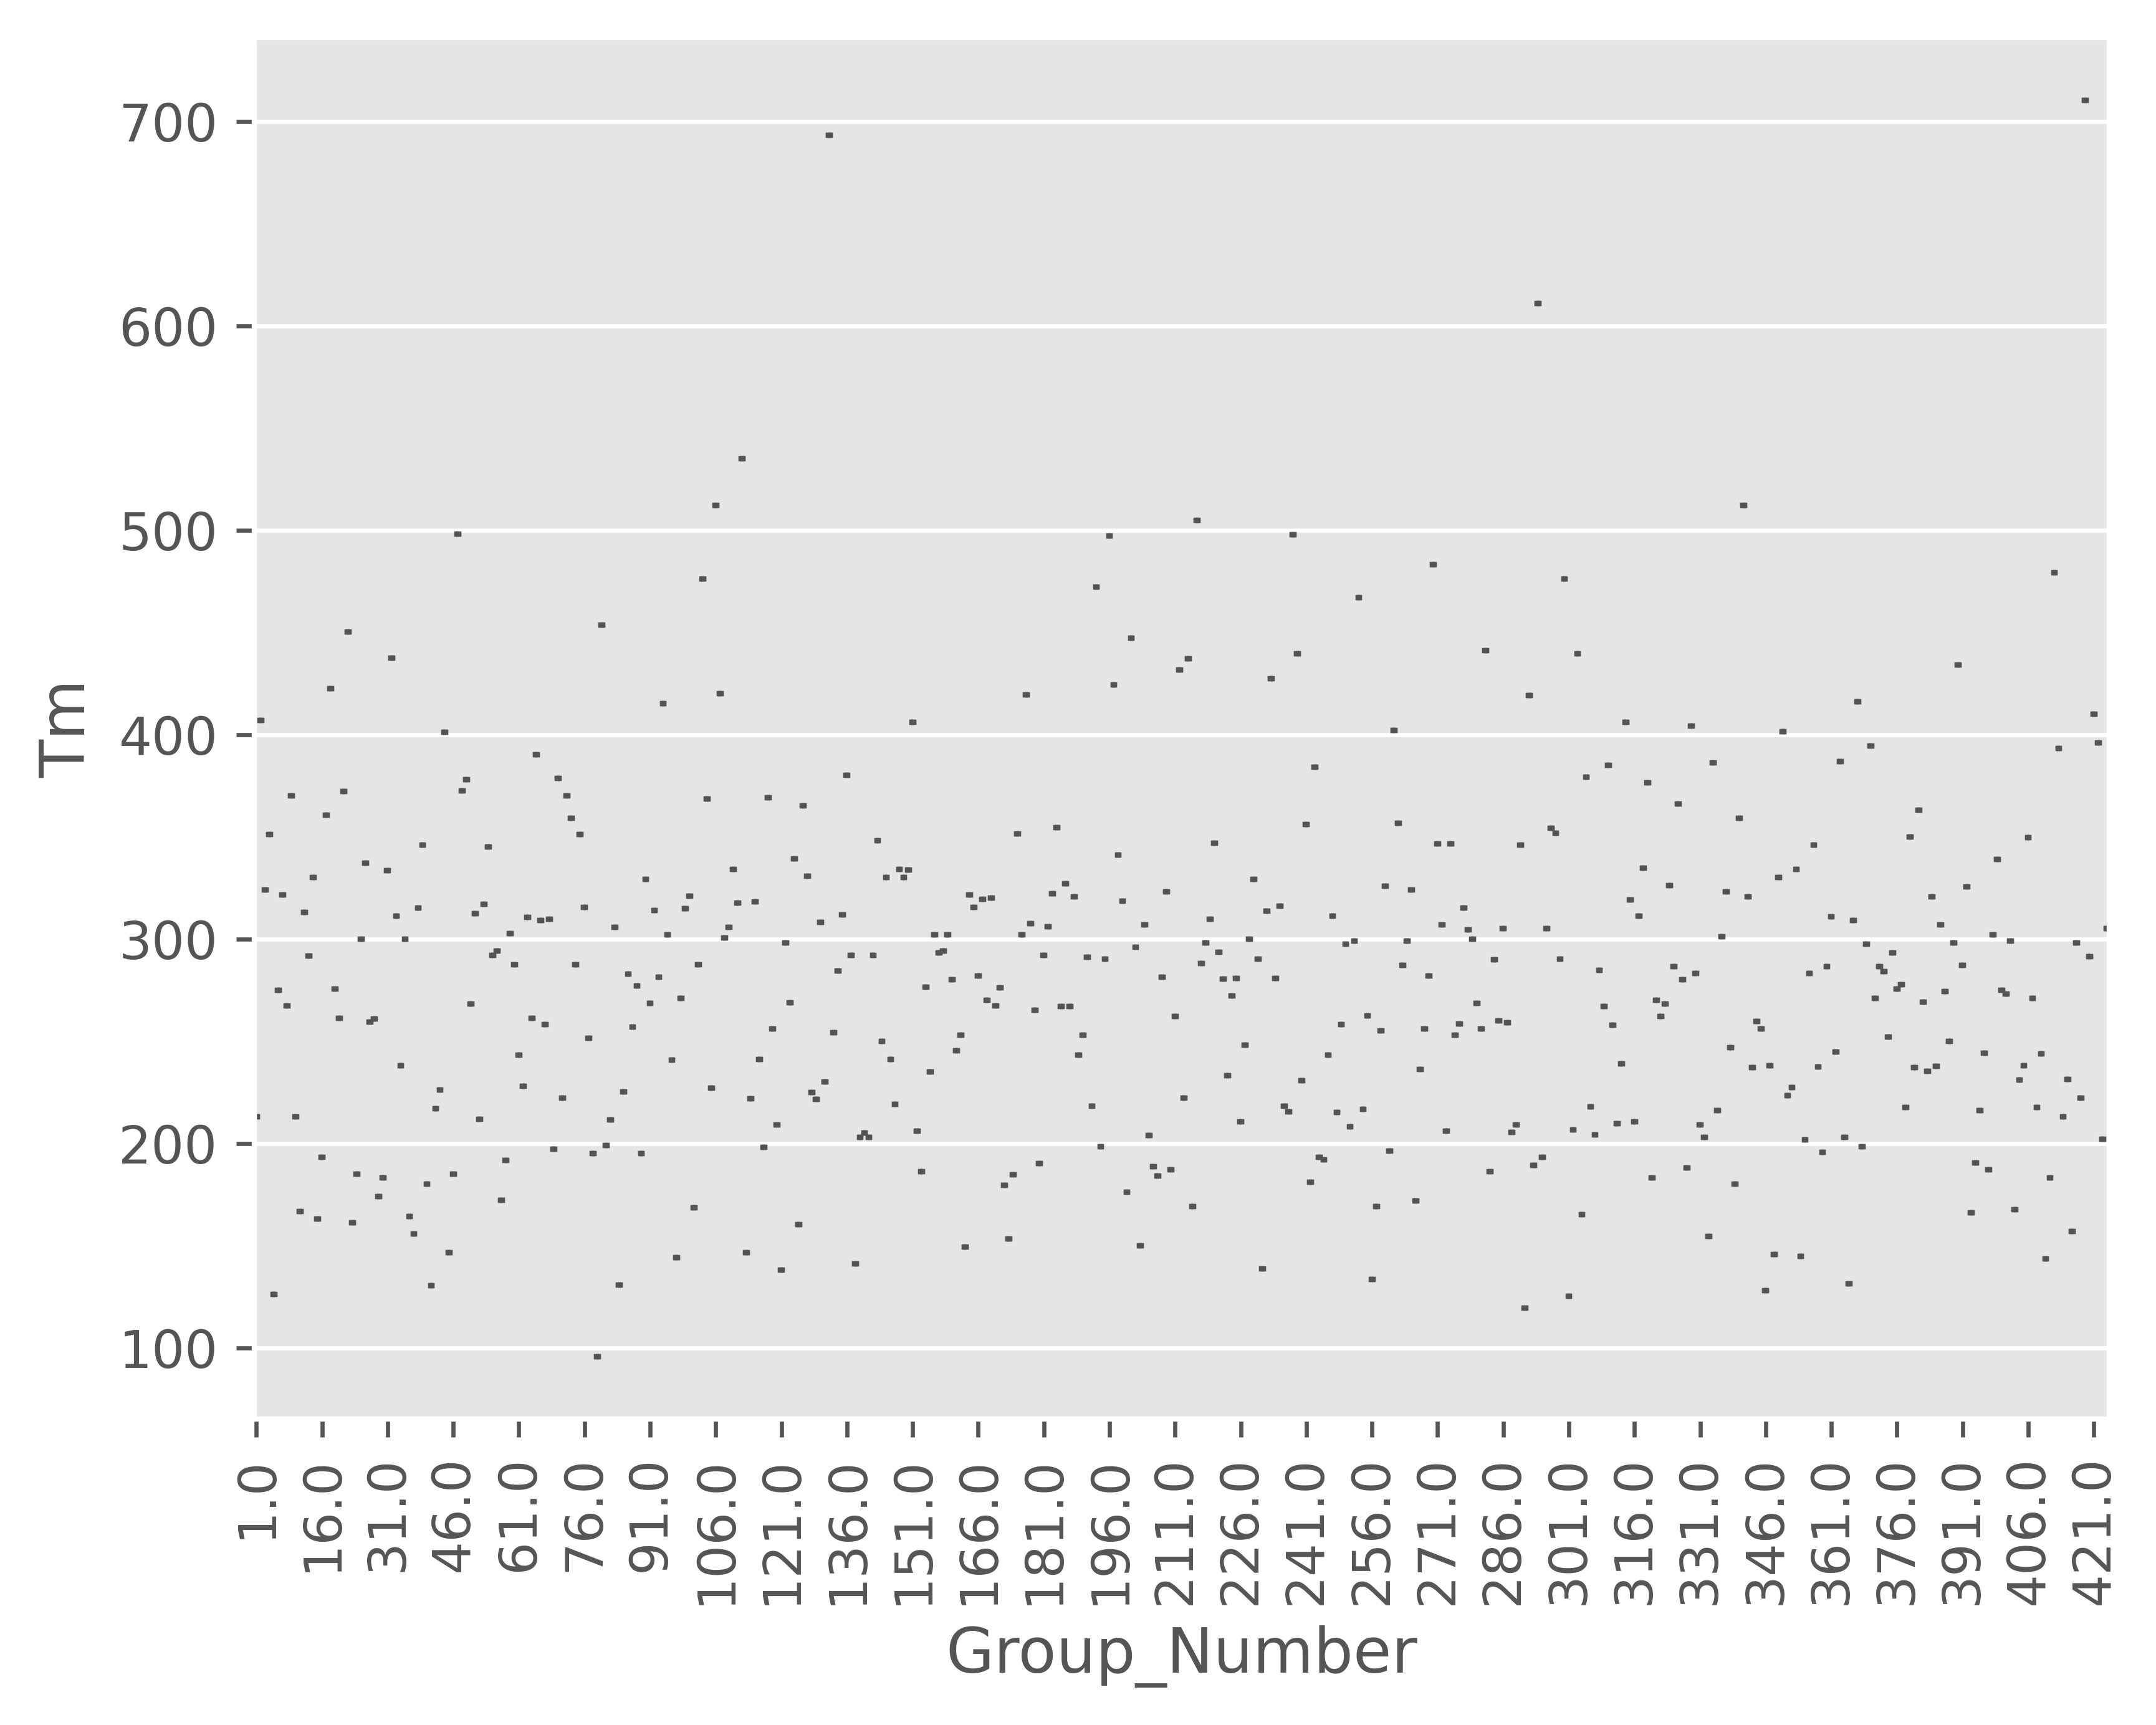

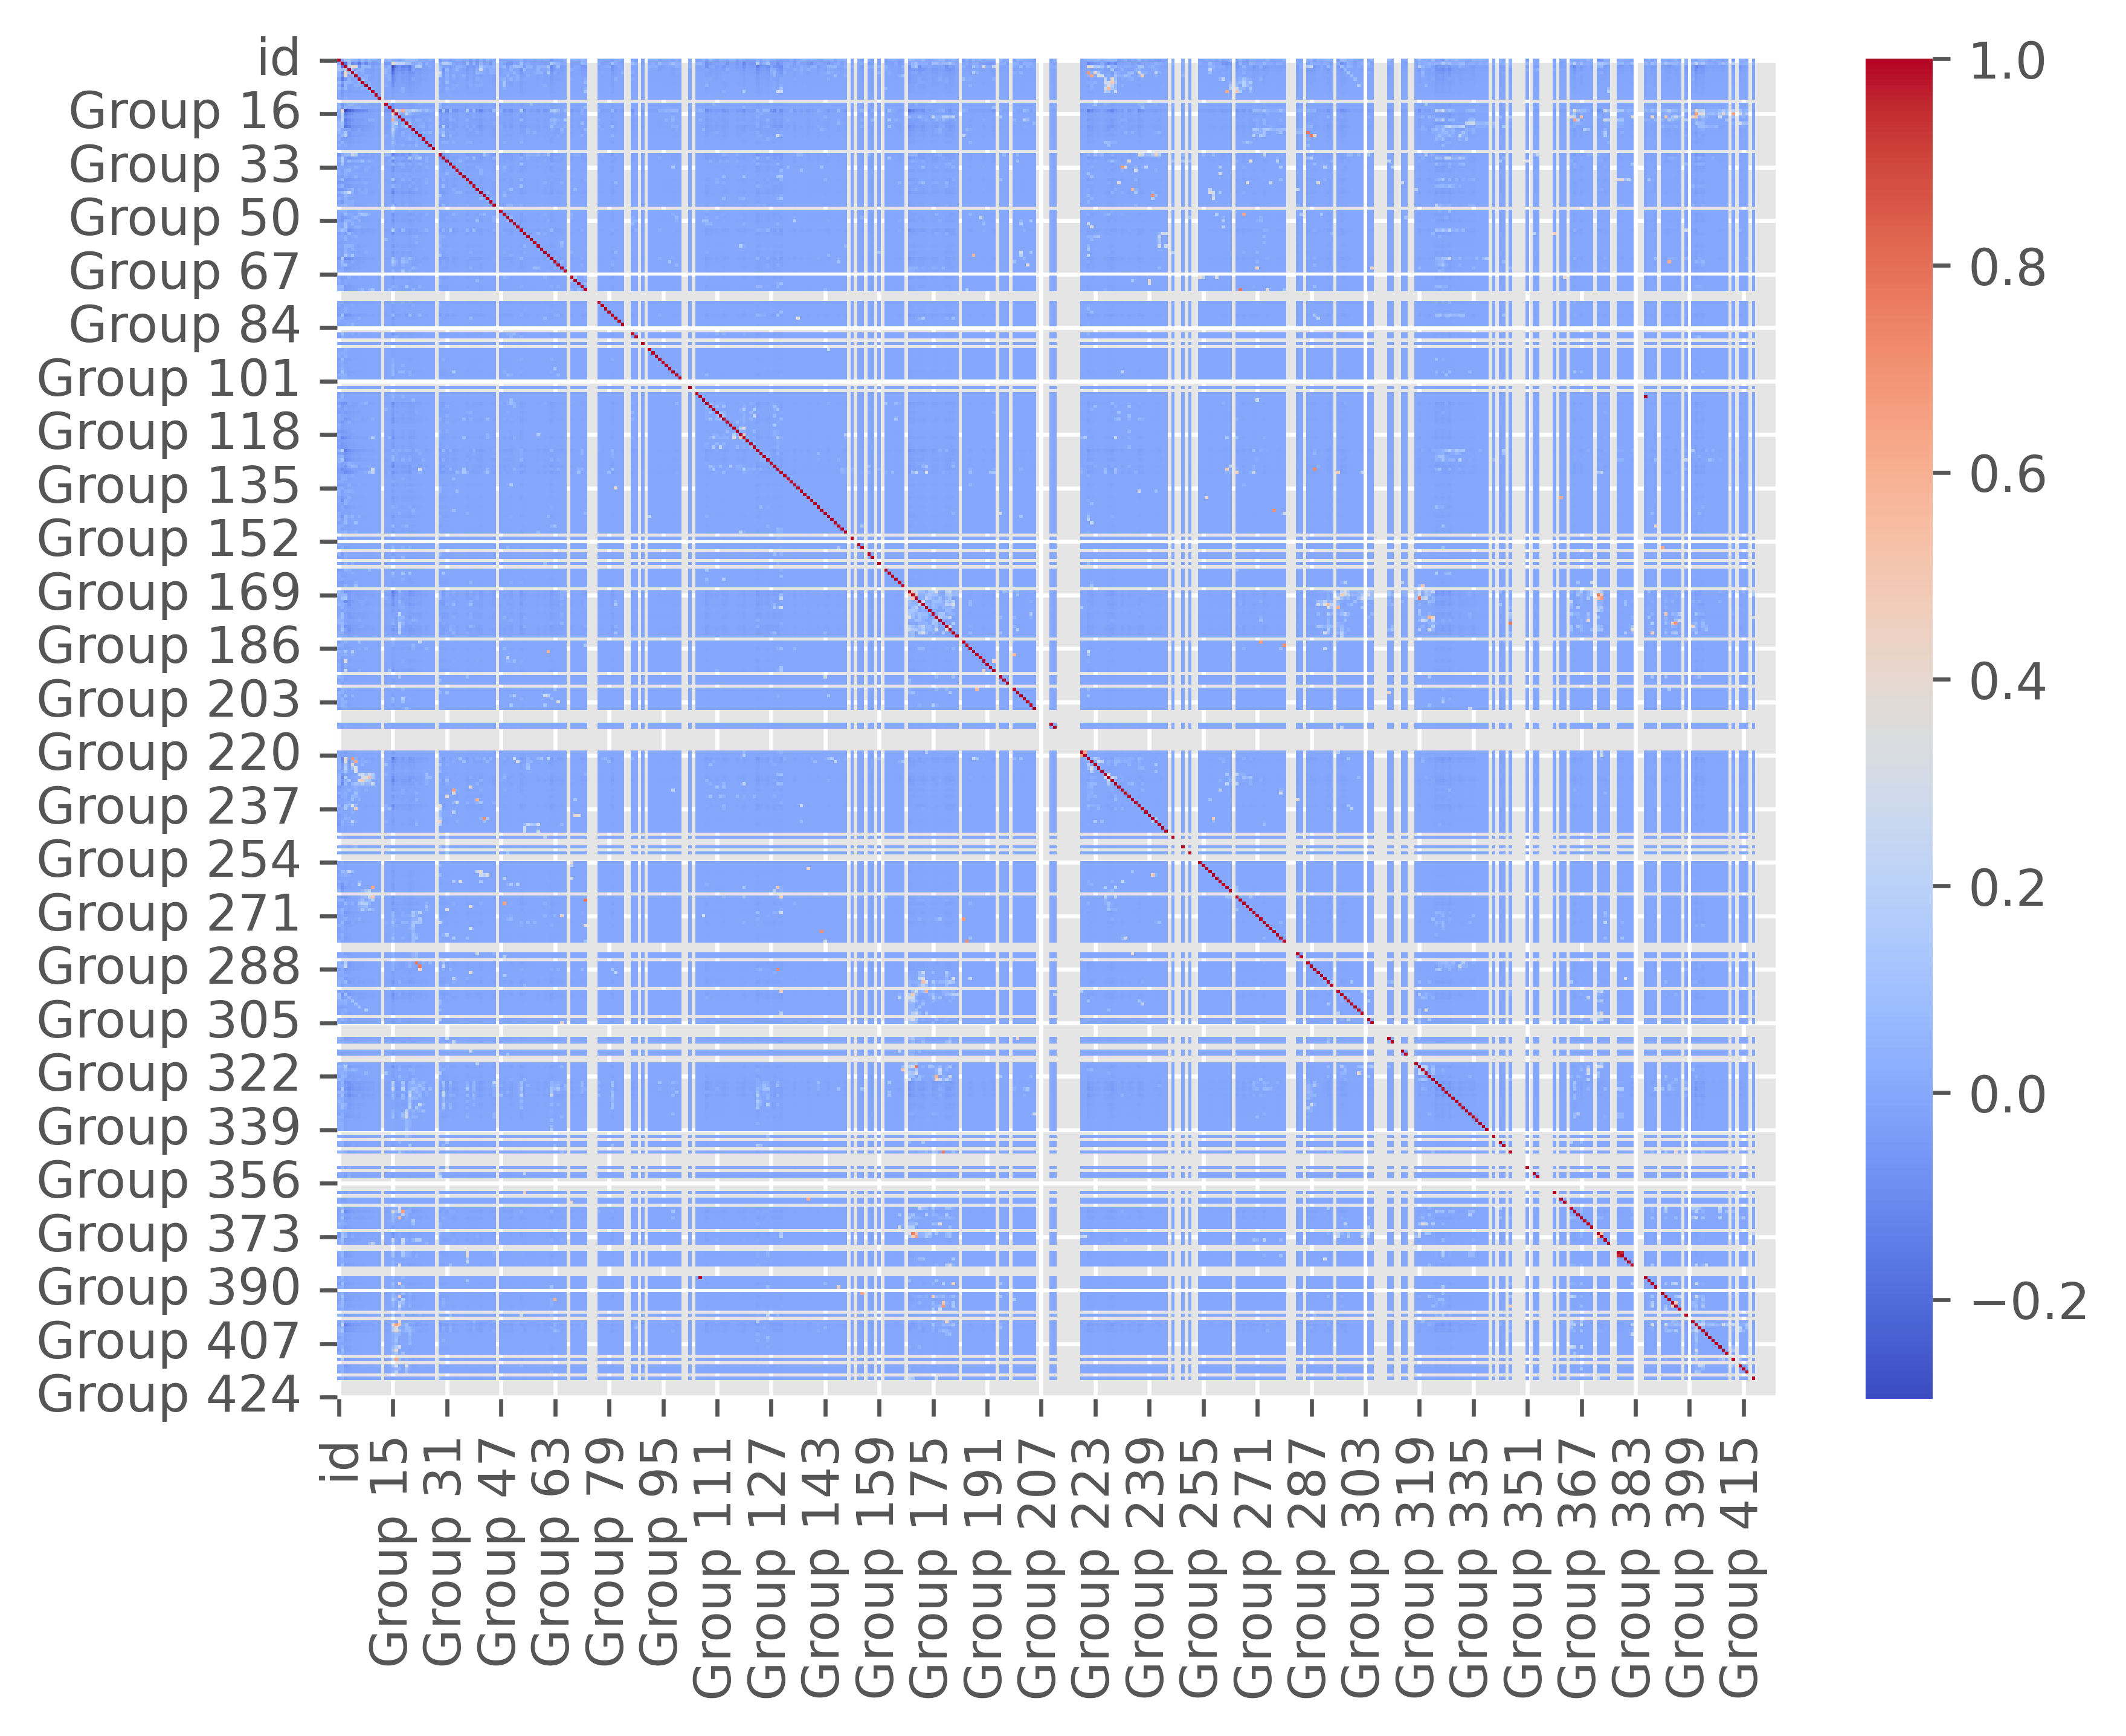

In [ ]:
#histogram
sns.histplot(data['Tm'], kde=True, color='#44A83B')
plt.title("Distribution of the melting points")
#plt.savefig("Graphics/Distribution_melting_points")
plt.show()
plt.close()

sns.boxplot(x=corr_df["Group_Number"], y=data['Tm'])
step = 15
ticks = list(range(0,corr_df['Group_Number'].max() + 1, step))
plt.xticks(ticks, rotation=90)
plt.show()

corr = data.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm')
plt.show()

In [5]:
#methods
#KNN 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

X_train = data[groups]
y_train = data['Tm']
X_test = test[groups]

param_grid_knn = {
    'n_neighbors': [1,3,5,7,9,11],
    'weights': ['uniform', 'distance'],
    'p': [1,2] #1 = manhattan, 2=euclidean
}

knn = KNeighborsRegressor()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_absolute_error')
grid_knn.fit(X_train, y_train)

print('Best parameters KNN:', grid_knn.best_params_)
print('Best score:', -grid_knn.best_score_)

y_pred = grid_knn.predict(X_test)

submission = pd.DataFrame({
    'id': test['id'],
    'Tm': y_pred})
submission.to_csv("Submissions/predictions_KNN.csv", index=False)



Best parameters KNN: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Best score: 43.38825638621208


In [11]:
! pip install optuna

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 17.0 MB/s  0:00:00

   ---------------------------------------- 0/7 [PyYAML]
   ---------------------------------------- 0/7 [PyYAML]
   ----- ---------------------------------- 1/7 [Mako]
   ----- ---------------------------------- 1/7 [Mako]
   ----- ---------------------------------- 1/7 [Mako]
   ----- ---------------------------------- 1/7 [Mako]
   ----- ---------------------------------- 1/7 [Mako]
   ----------- ---------------------------- 2/7 [greenlet]
   ----------- ---------------------------- 2/7 [greenlet]
   ----------- ---------------------------- 2/7 [greenlet]
   ----------------- ---------------------- 3/7 [colorlog]
   ---------------------- ----------------- 4/7 [sqlalchemy]
   ---------------------- ----------------- 4/7 [sqlalchemy]
   ---------------------- ----------------- 4/7 [sqlalchemy]
   ---------------------- ----------------- 4/7 

In [ ]:
#KNN with optona for hyperparamter search

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.model_selection import cross_val_score
def objective(trial):
    # Hyperparameter-Raum für KNN
    n_neighbors = trial.suggest_int("n_neighbors", 1, 15)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_categorical("p", [1, 2])

    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p
    )

    # Cross-Validation MAE 
    score = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring="neg_mean_absolute_error"
    )

    return -score.mean()   #

# Optuna-studie 
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best Parameter:", study.best_params)
print("Best MAE:", study.best_value)

# Modell with best parameters
best_knn = KNeighborsRegressor(**study.best_params)
best_knn.fit(X_train, y_train)

# Prediction for test
y_pred = best_knn.predict(X_test)

submission = pd.DataFrame({
    'id': test['id'],
    'Tm': y_pred
})

submission.to_csv("Submissions/predictions_KNN_optuna.csv", index=False)


Best trial: 19. Best value: 43.3883: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Beste Parameter: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}
Beste MAE: 43.38825638621208
Submission gespeichert.


In [6]:
#neural network
from sklearn.neural_network import MLPRegressor

param_grid_mlp = {
    'hidden_layer_sizes': [(64,64), (128,64)],
    'activation': ['relu'],
    'alpha': [0.0001, 0.001],       # Regularisierung
    'learning_rate': ['adaptive']
}

#mlp = MLPRegressor(max_iter=300)
mlp = MLPRegressor(max_iter=500, early_stopping=True, random_state=0)

grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=2, scoring="neg_mean_absolute_error",n_jobs=-1 )
grid_mlp.fit(X_train, y_train)

print("Beste Parameter MLP:", grid_mlp.best_params_)
print("Bester Score:", -grid_mlp.best_score_)

y_pred = grid_mlp.predict(X_test)

submission = pd.DataFrame({
    'id': test['id'],
    'Tm': y_pred})
submission.to_csv("Submissions/predictions_neural_network_fast.csv", index=False)



Beste Parameter MLP: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 64), 'learning_rate': 'adaptive'}
Bester Score: 39.12846646924251


In [7]:
#assignment of groups to functional groups
!pip uninstall -y numpy
!pip install "numpy==1.26.4"
from rdkit import Chem


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


You can safely remove it manually.
You can safely remove it manually.


  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)


In [8]:

functional_groups = {
    "alcohol":     Chem.MolFromSmarts("[OX2H]"),
    "carboxylic_acid": Chem.MolFromSmarts("C(=O)[OH]"),
    "amine":       Chem.MolFromSmarts("[NX3;H2,H1;!$(NC=O)]"),
    "amide":       Chem.MolFromSmarts("C(=O)N"),
    "ketone":      Chem.MolFromSmarts("C(=O)[#6]"),
    "aldehyde":    Chem.MolFromSmarts("[CX3H1](=O)[#6]"),
    "ether":       Chem.MolFromSmarts("[$([OD2]([#6])[#6])]"),
    "halogen":     Chem.MolFromSmarts("[F,Cl,Br,I]"),
    "aromatic":    Chem.MolFromSmarts("a"),
    "alkene":      Chem.MolFromSmarts("C=C"),
    "alkyne":      Chem.MolFromSmarts("C#C"),
}
def detect_functional_groups(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []

    found = []
    for name, pattern in functional_groups.items():
        if mol.HasSubstructMatch(pattern):
            found.append(name)
    return found
data['functional_groups'] = data['SMILES'].apply(detect_functional_groups)
data.head()


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424,functional_groups
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[halogen, alkene]"
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[aromatic]
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[aromatic]
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[alcohol, carboxylic_acid, ketone, alkyne]"
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[]


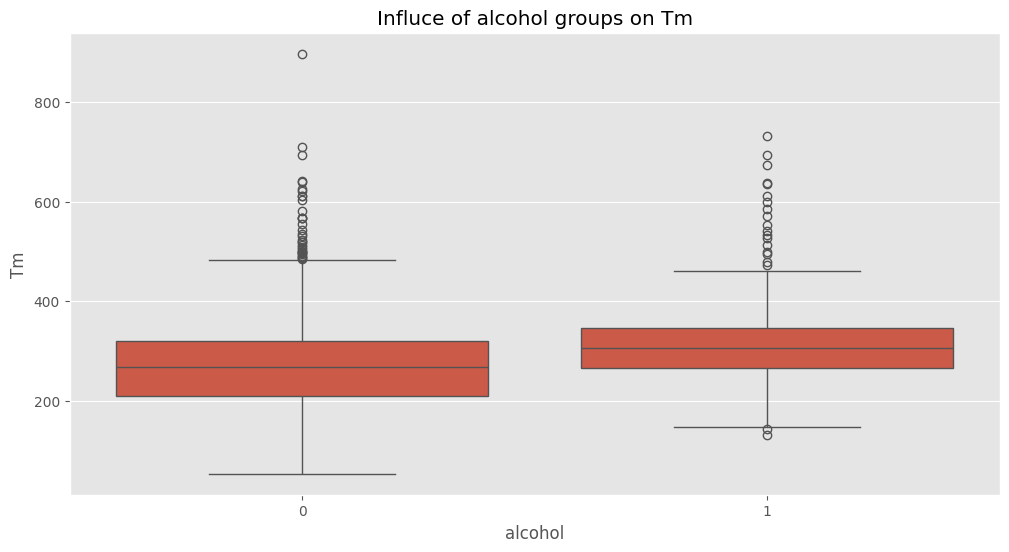

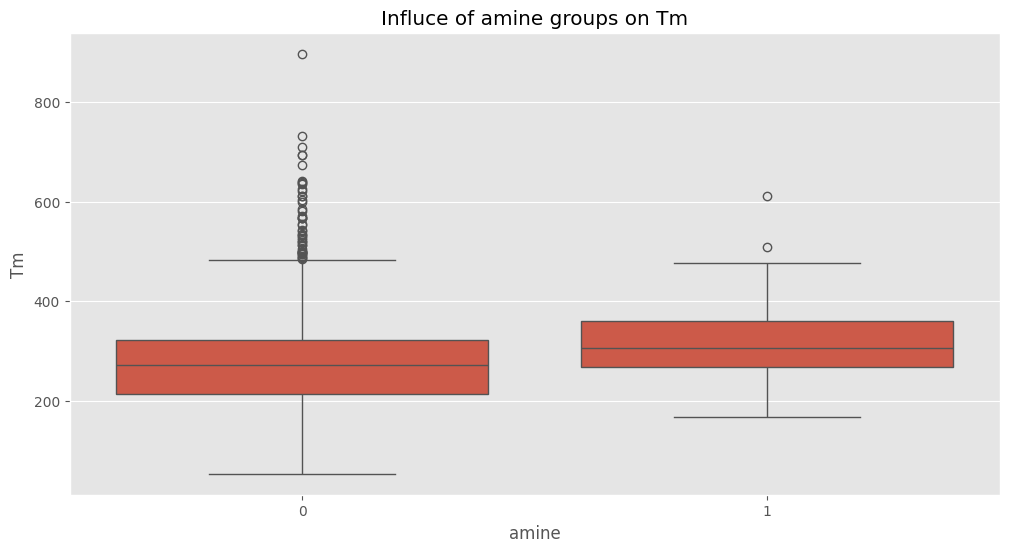

In [9]:

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
fg_ohe = pd.DataFrame(mlb.fit_transform(data['functional_groups']),
                      columns=mlb.classes_,
                      index=data.index)

data = pd.concat([data, fg_ohe], axis=1)


plt.figure(figsize=(12,6))
sns.boxplot(x='alcohol', y='Tm', data=data)
plt.title("Influce of alcohol groups on Tm")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='amine', y='Tm', data=data)
plt.title("Influce of amine groups on Tm")
plt.show()